In [ ]:
# connect the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# workspace
%cd /content/drive/MyDrive/ML_GroupProject/jjh_ML/

/content/drive/MyDrive/ML_GroupProject/jjh_ML


In [ ]:
# check the files
%ls

'Copy of here_math_latex.ipynb'   images/                only_one/
 current_math_latex.ipynb         images2/               output/
 dataset/                         math_latex.ipynb       try_new_math_latex.ipynb
 dataset_unuse/                   mnist_data/
 grayscale_image.png              new_math_latex.ipynb


In [ ]:
import os

# Manipulation on data
import numpy as np

# plot the data
import matplotlib.pyplot as plt

# reload python library
%load_ext autoreload
%autoreload 2

import cv2
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

import cv2
from PIL import Image, ImageFilter, ImageEnhance
from cv2 import boundingRect

from torchvision import datasets, transforms


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# constant variable

INPUT_FOLDER_test = 'images2/'
INPUT_FOLDER = 'dataset/'
VALID_INPUT_FOLDER = 'dataset/'
OUTPUT_FOLDER = 'output/'

In [ ]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 5

IMG_SIZE = 32
N_CLASSES = 19

In [ ]:
def get_all_images(label_map):
  dataset = []
  for foldername in os.listdir(INPUT_FOLDER):
    if foldername.startswith("."): continue
    else:
      img_name = INPUT_FOLDER+foldername+"/"
      for img in os.listdir(img_name):
      # Read the image
        image = cv2.imread(img_name+img)

        if img.startswith("."):continue
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the image to 32x32
        resized_image = cv2.resize(gray_image, (32, 32))

        # Print the resized image
        label = label_map.get(foldername, -1)
        #print("Integer label:", foldername, label)
        dataset.append([np.array(resized_image), label])

# Apply the transformation to each image in the dataset
  return dataset

math_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'mul': 10, 'div': 11, 'sub': 12, 'add': 13, 'x': 14, 'y': 15, 'z': 16, 'eq': 17, 'dev': 18}
#math_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'mul': 10, 'div': 11, 'sub': 12, 'add': 13, 'eq': 17}
full_image_data = get_all_images(math_map)

In [ ]:
class CustomEquationDataset(Dataset):
    def __init__(self, label, data, transforms=None):
        self.label = label
        self.image_data = data
        self.transforms = transforms
        self.data = self._load_data()


    def _load_data(self):
        dataset=[]
        print(self.label)
        for i in self.label:
          dataset.append(self.image_data[i])
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]


        # Apply transformations if specified
        if self.transforms:
            img = Image.fromarray(img)
            img = self.transforms(img)

        label = torch.tensor(label, dtype=torch.long)

        return img, label

    def __plot_item__(self, idx):
        img, _ = self.data[idx]

        plt.imshow(np.asarray(img), cmap='gray')
        plt.show()
        return img

In [ ]:
def div_images(image_data):
  indices = np.random.permutation(len(image_data))
  split_index = int(len(image_data) * .6)
  train_indices = indices[:split_index]
  test_indices = indices[split_index:]
  print(train_indices)
  return [train_indices, test_indices]

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset

index = div_images(full_image_data)
# define transforms, standardizing the input size
transforms = transforms.Compose([transforms.Resize((32, 32)),  # Resize the images to a 28x28 resolution
                                 transforms.ToTensor()])       # Convert the images to PyTorch tensors




train_dataset = CustomEquationDataset(label=index[0], data=full_image_data, transforms=transforms)
valid_dataset = CustomEquationDataset(label=index[1], data=full_image_data,transforms=transforms)


one_dataset = CustomEquationDataset(label=[index[1][0]], data=full_image_data,transforms=transforms)

[5745 3334 6279 ... 7396 6440 4887]
[5745 3334 6279 ... 7396 6440 4887]
[6975 6150 3931 ...  937 1158 5157]
[6975]


In [ ]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

one_loader = DataLoader(dataset=one_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [ ]:
def train(train_loader, model, criterion, optimizer):
    '''
    Train one epoch.
    '''

    model.train()
    running_loss = 0

    for X, y_true in train_loader:

        optimizer.zero_grad()

        # Forward pass
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)

        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop.
    Returns the model and the loss on the test set.
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:

        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)

    return model, epoch_loss

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1):
    '''
    Function defining the entire training loop
    '''

    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):

            train_acc = get_accuracy(model, train_loader,)
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    performance = {
        'train_losses':train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_accs,
        'valid_acc':valid_accs
    }

    return model, optimizer, performance

In [ ]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            # Forward pass and record loss
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n



def plot_performance(performance):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn-v0_8')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key)
        else:
            ax[1].plot(value, label=key)
    ax[0].set(title="Loss  over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        # Define the layers
        self.features_from_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes)
        )

    def forward(self, x):
        features = self.features_from_layers(x)
        features_flat = torch.flatten(features, 1)
        logits = self.classifier(features_flat)
        probs = F.softmax(logits, dim=1)
        return logits, probs


In [ ]:
class MLP(nn.Module):

    def __init__(self, layers, dropout_prob = 0.5):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.hidden_layers.append(nn.BatchNorm1d(layers[i+1]))  # Add batch normalization
            if i != len(layers)-2:
                self.hidden_layers.append(nn.Tanh())
                self.hidden_layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer after ReLU
        self.hidden_layers = nn.Sequential(*self.hidden_layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.hidden_layers(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

In [ ]:
model, optimizer, performance_1 = training_loop(model, criterion, optimizer, train_loader, valid_loader, 25)

05:26:58 Epoch: 0	Train loss: 0.2146	Valid loss: 0.4625	Train accuracy: 94.05	Valid accuracy: 85.69
05:27:05 Epoch: 1	Train loss: 0.1966	Valid loss: 0.4475	Train accuracy: 95.00	Valid accuracy: 87.48
05:27:12 Epoch: 2	Train loss: 0.1661	Valid loss: 0.4720	Train accuracy: 94.59	Valid accuracy: 86.59
05:27:19 Epoch: 3	Train loss: 0.1649	Valid loss: 0.4268	Train accuracy: 95.30	Valid accuracy: 88.34
05:27:26 Epoch: 4	Train loss: 0.1599	Valid loss: 0.5200	Train accuracy: 93.36	Valid accuracy: 85.60
05:27:33 Epoch: 5	Train loss: 0.1602	Valid loss: 0.4343	Train accuracy: 96.15	Valid accuracy: 87.92
05:27:40 Epoch: 6	Train loss: 0.1347	Valid loss: 0.4218	Train accuracy: 95.58	Valid accuracy: 88.58
05:27:47 Epoch: 7	Train loss: 0.1331	Valid loss: 0.4305	Train accuracy: 97.12	Valid accuracy: 88.76
05:27:53 Epoch: 8	Train loss: 0.1258	Valid loss: 0.4279	Train accuracy: 97.32	Valid accuracy: 88.76
05:28:00 Epoch: 9	Train loss: 0.1073	Valid loss: 0.4855	Train accuracy: 95.56	Valid accuracy: 87.00


In [ ]:
# Function for extracting symbols from an image featuring a white background and black colored symbols
def extract_symbols(image_file, verbose = False):
    # Load image and invert colors
    img = cv2.imread(image_file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # img_gray = np.asarray(img_gray)

    img_gray = (255 - img_gray)
    orig_img = img_gray.copy() # clone for extracting symbols later


    # Create dilated image to capture potential loose points (such as dots in division symbol)
    # Threshold the grayscale image to create a binary image
    _, binary_image = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

    # Dilate the binary image
    kernel = np.ones((10, 1), np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations=5)

    # Apply distance transform to the dilated binary image
    dist_transform = cv2.distanceTransform(dilated_image, cv2.DIST_L2, 3)

    # Find contours
    contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    b_boxes = []
    for c in range(len(contours)):
        # Only take contours of symbols without parents to avoid duplicate outlines
        if hierarchy[0][c][3] == -1:
            brect = cv2.boundingRect(contours[c])
            b_boxes.append(brect)
            cv2.rectangle(img_gray, (brect[0], brect[1]), (brect[0] + brect[2], brect[1] + brect[3]), (255, 255, 255), 2)

    # Sort bounding boxes after appearance in x-direction
    b_boxes = sorted(b_boxes)

    if verbose:
        print("Original image:")
        plt.figure(figsize=(10,10))
        plt.imshow((255 - orig_img), cmap='gray')
        plt.show()
        print("All bounding boxes of all symbols:")
        plt.figure(figsize=(10,10))
        plt.imshow((255 - img_gray), cmap='gray')
        plt.show()
        print("Extracted symbols:")

    # b_boxes are formatted as [x_pos, y_pos, width, height]
    #print(b_boxes)

    # Get all symbols as separate images
    symbols = []
    for box in b_boxes:
        x,y,w,h = box
        # symbol_size = (h, w)
        # print(symbol_size)
        symbol_img = orig_img[y : y + h, x : x + w]
        symbols.append(255-symbol_img)

    if verbose:
        plt.figure(figsize=(15,5))
        for x in range(len(b_boxes)):
            plt.subplot(1,len(b_boxes), x+1)
            plt.imshow((255 - symbols[x]), cmap='gray')
        plt.show()

    return symbols


In [ ]:
import cv2

def resize_keep_aspect_ratio(image, target_size):
    # Get original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate aspect ratio
    ratio = float(target_size) / max(original_height, original_width)

    # Calculate new dimensions maintaining aspect ratio
    new_height = int(round(original_height * ratio))
    new_width = int(round(original_width * ratio))

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Calculate padding
    pad_width = target_size - resized_image.shape[1]
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad

    # Pad the image with white pixels equally on left and right sides
    padded_image = cv2.copyMakeBorder(resized_image, 0, 0, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(255, 255, 255))

    return padded_image


In [ ]:
from torchvision import datasets, transforms
class TestDataset(Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        self.data = self._load_data()


    def _load_data(self):
      dataset = []
      for imagename in os.listdir(INPUT_FOLDER_test):

          if imagename.startswith("."):continue
          symbols = extract_symbols(INPUT_FOLDER_test+imagename, True)

          for sym in symbols:
            formatted_img = resize_keep_aspect_ratio(sym, 32)
            dataset.append(formatted_img)

      # Assuming 'input_tensor' is your PyTorch tensor
      return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]

        # Apply transformations if specified
        if self.transforms:
            img = Image.fromarray(img)
            img = self.transforms(img)

        return img

    def __plot_item__(self, idx):
        img = self.data[idx]

        plt.imshow(np.asarray(img), cmap='gray')
        plt.show()
        return img

# define transforms, standardizing the input size
transforms = transforms.Compose([transforms.Resize((32, 32)),  # Resize the images to a 28x28 resolution
                                 transforms.ToTensor()])       # Convert the images to PyTorch tensors


# Create instances of the custom dataset
test_dataset = TestDataset(transforms=transforms)

for i in range(test_dataset.__len__()):
  print("Input shape:", test_dataset.__plot_item__(i))


In [ ]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

# test_loader1 = DataLoader(dataset=test1_dataset,
#                           batch_size=BATCH_SIZE,
#                           shuffle=False)

Predicted label for item 0: 3


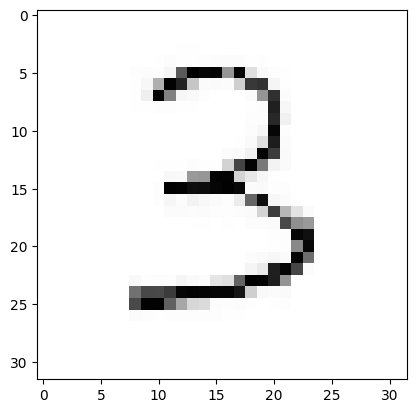

Predicted label for item 1: 1


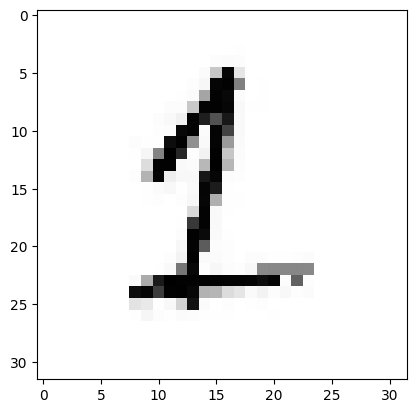

Predicted label for item 2: add


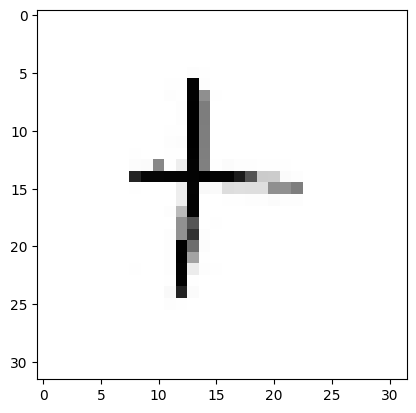

Predicted label for item 3: 7


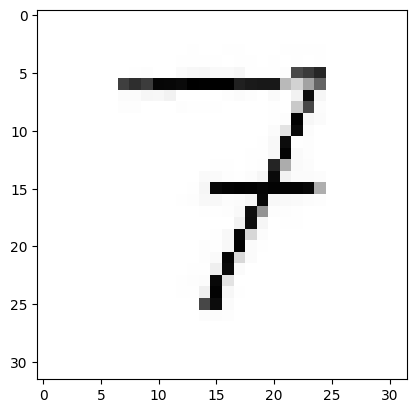

Predicted label for item 4: 3


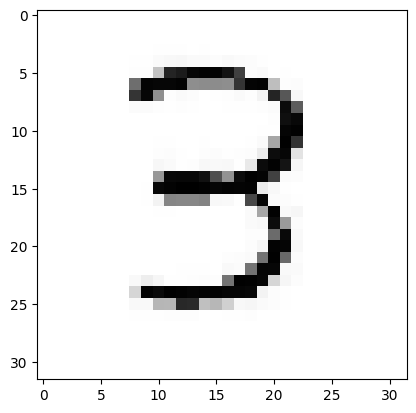

Predicted label for item 5: div


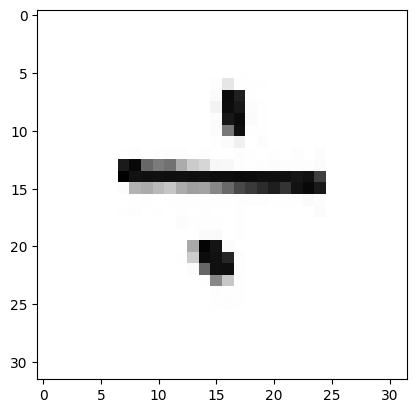

Predicted label for item 6: 9


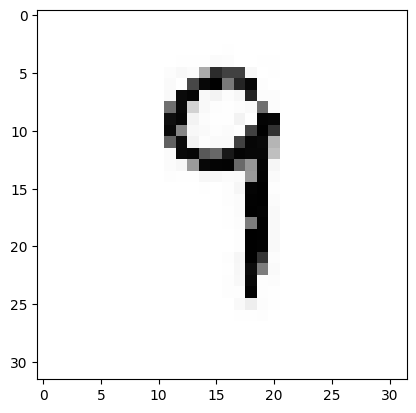

Predicted label for item 7: 3


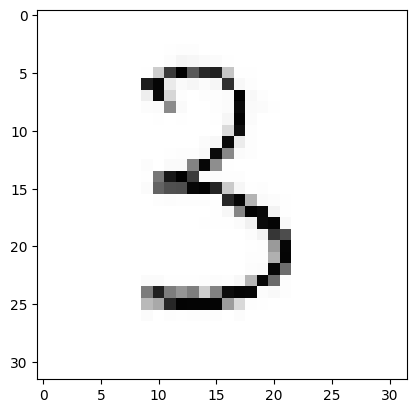

Predicted label for item 8: eq


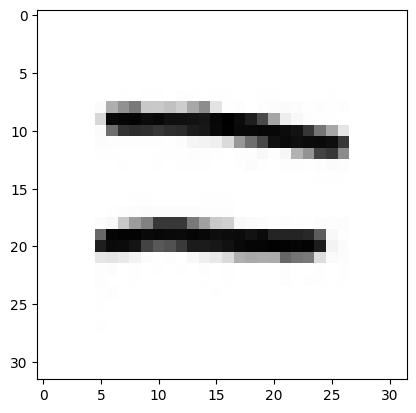

Predicted label for item 9: 1


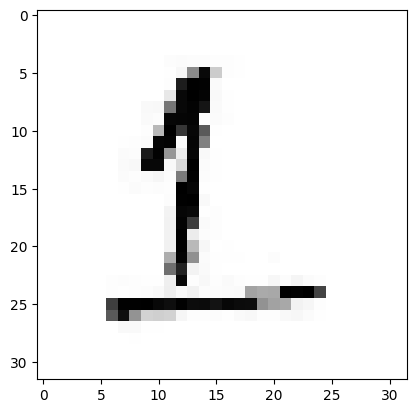

Predicted label for item 10: 0


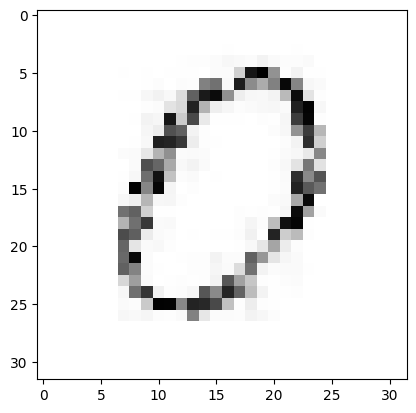

Predicted label for item 11: sub


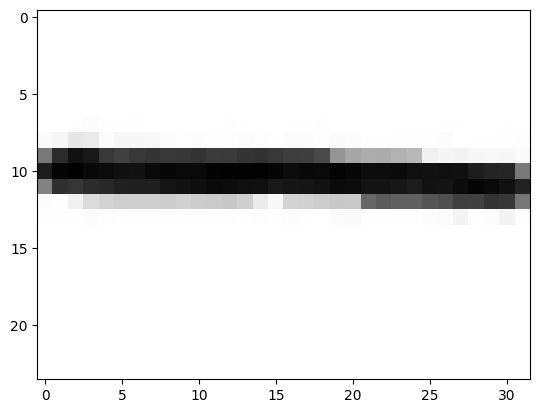

Predicted label for item 12: 4


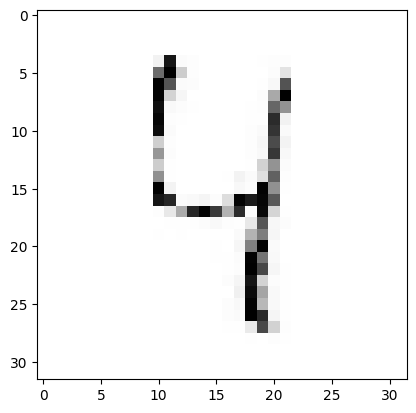

Predicted label for item 13: 9


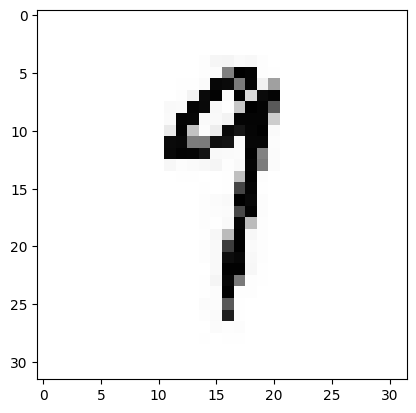

Predicted label for item 14: add


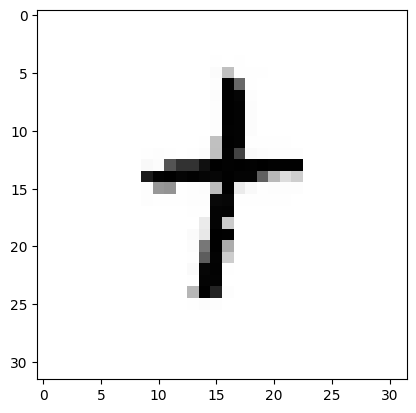

Predicted label for item 15: 1


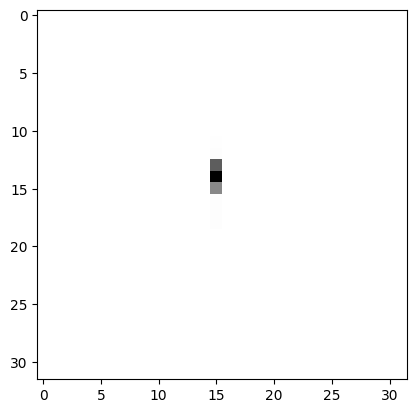

Predicted label for item 16: 2


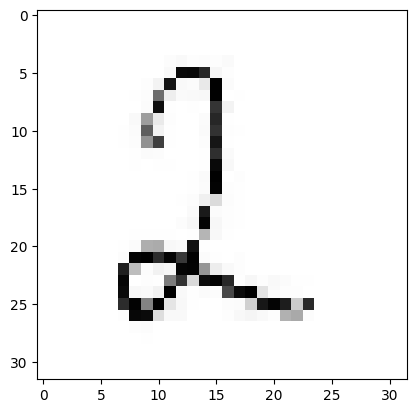

Predicted label for item 17: 1


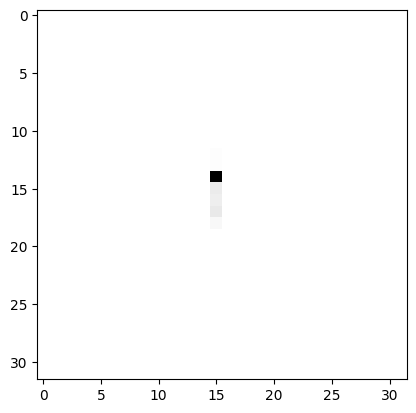

Predicted label for item 18: 7


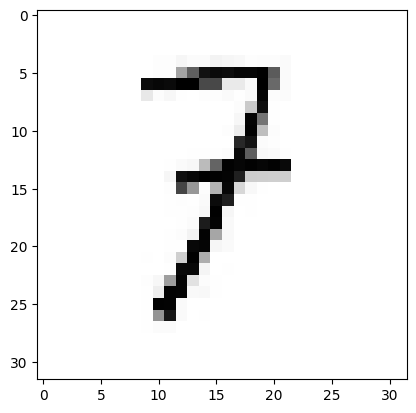

Predicted label for item 19: eq


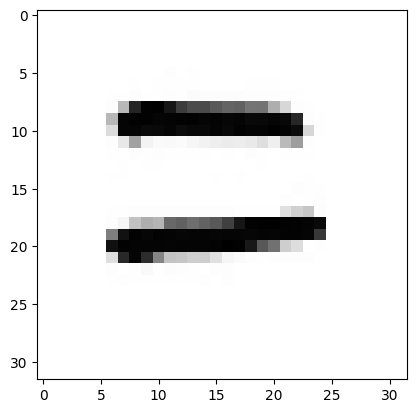

Predicted label for item 20: 5


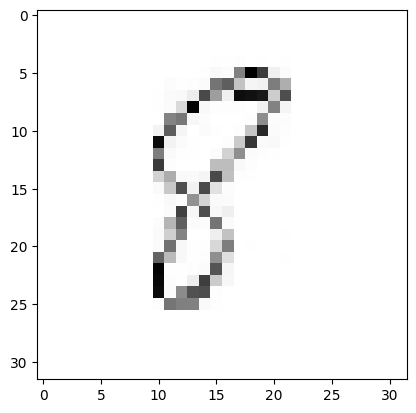

Predicted label for item 21: 6


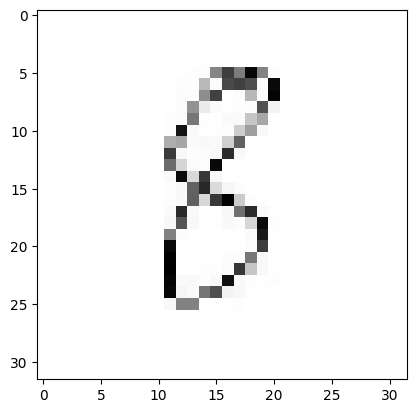

Predicted label for item 22: div


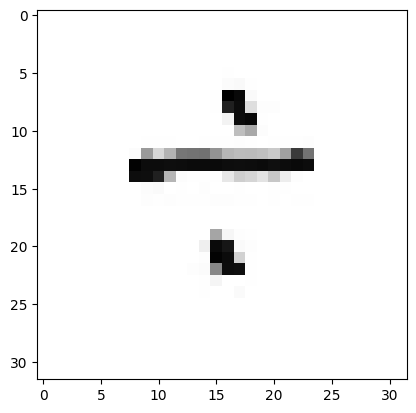

Predicted label for item 23: 8


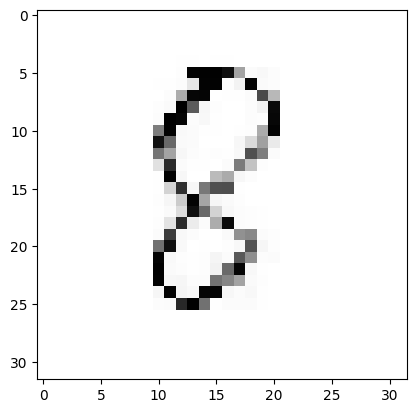

Predicted label for item 24: 7


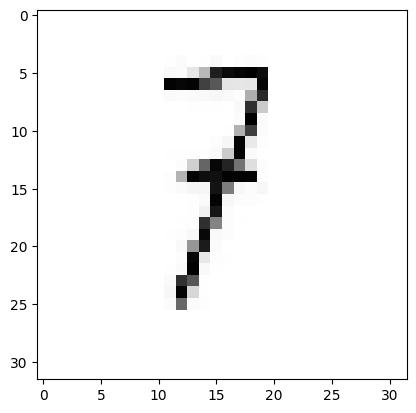

Predicted label for item 25: sub


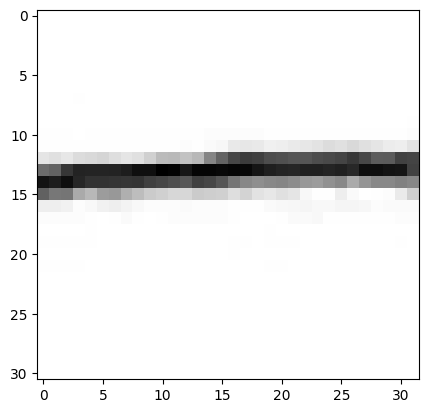

Predicted label for item 26: 7


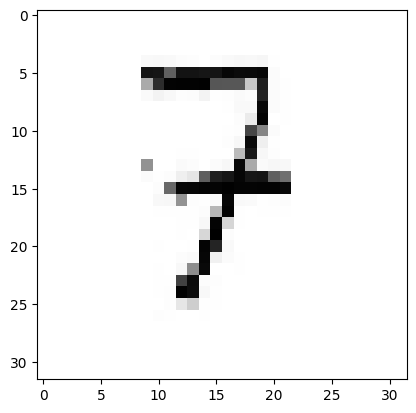

Predicted label for item 27: 5


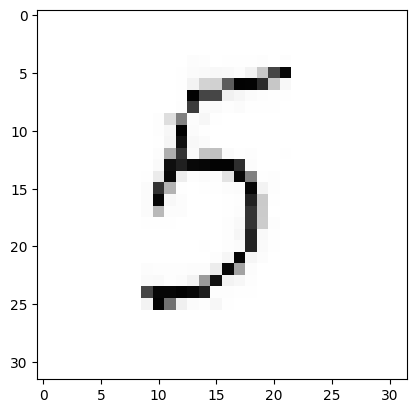

Predicted label for item 28: eq


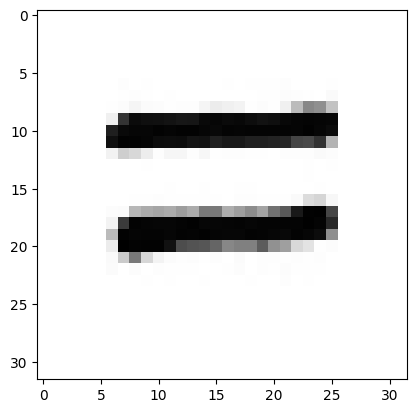

Predicted label for item 29: 8


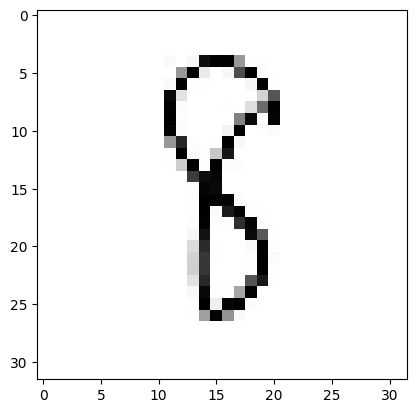

Predicted label for item 30: 8


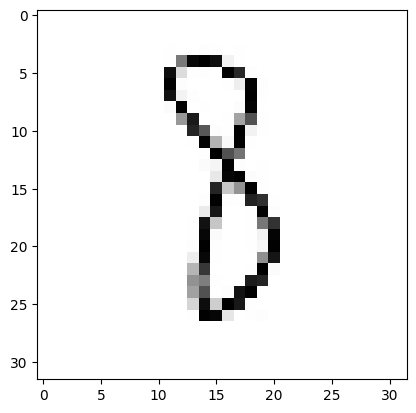

Predicted label for item 31: add


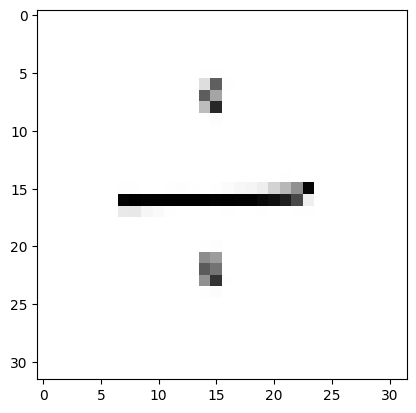

Predicted label for item 32: 8


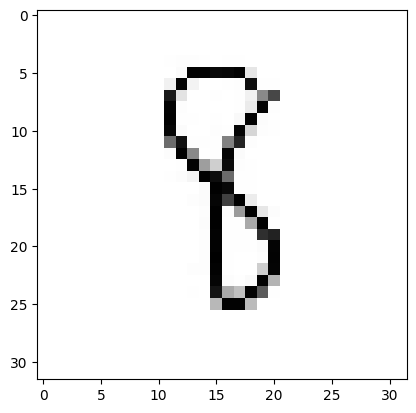

Predicted label for item 33: 7


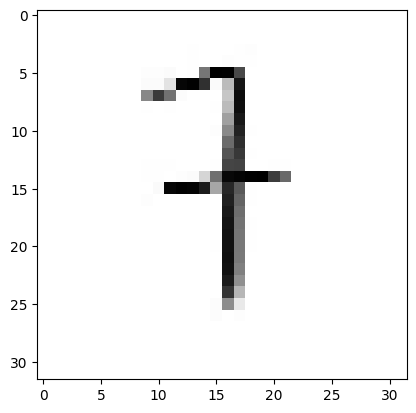

Predicted label for item 34: sub


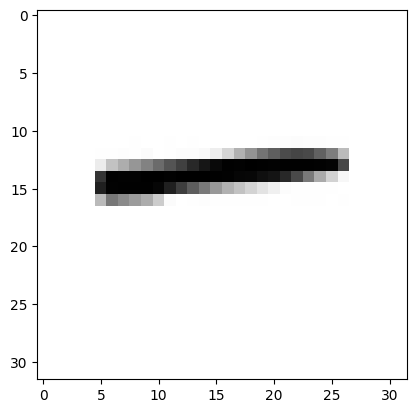

Predicted label for item 35: add


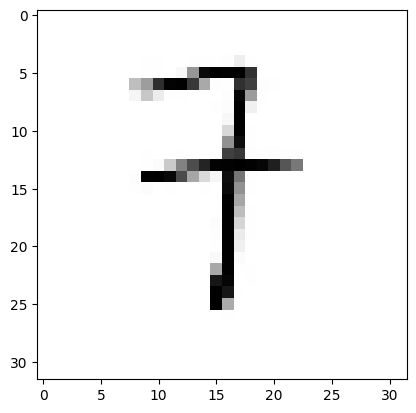

Predicted label for item 36: 5


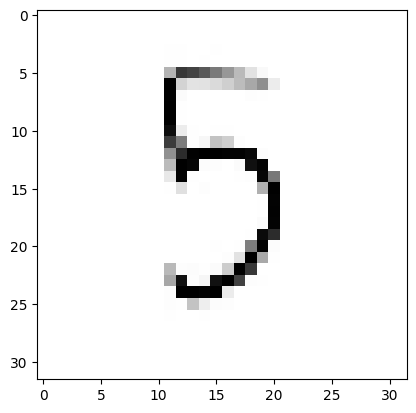

Predicted label for item 37: mul


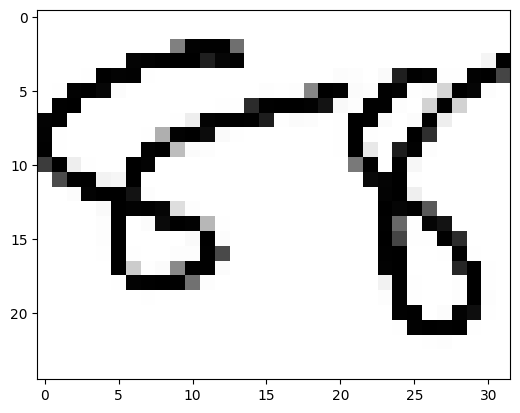

Predicted label for item 38: div


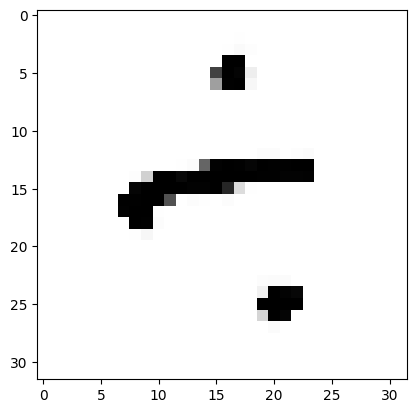

Predicted label for item 39: 5


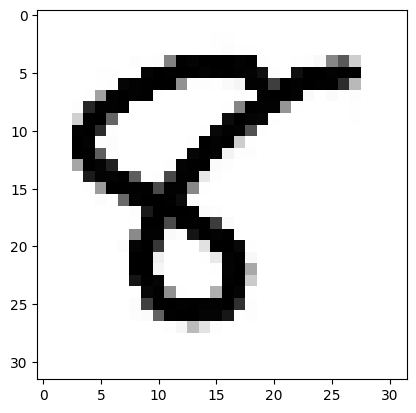

Predicted label for item 40: 7


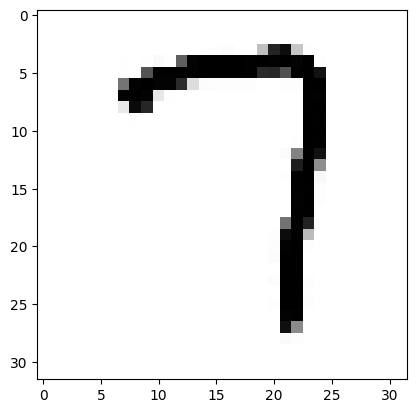

Predicted label for item 41: eq


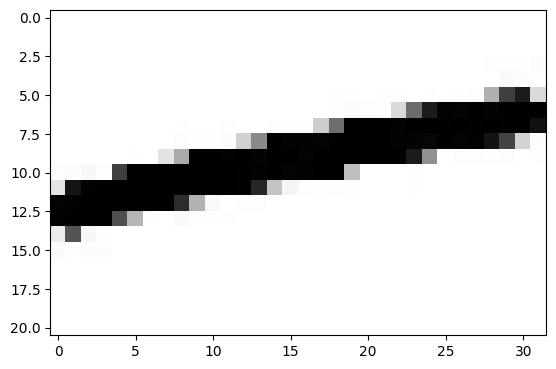

Predicted label for item 42: 7


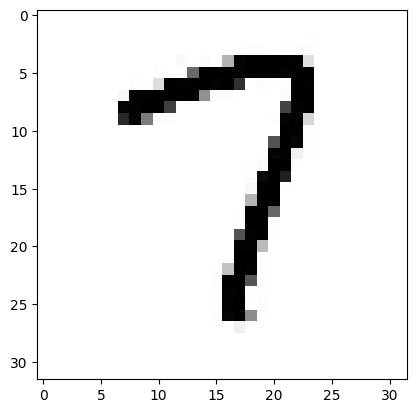

Predicted label for item 43: 8


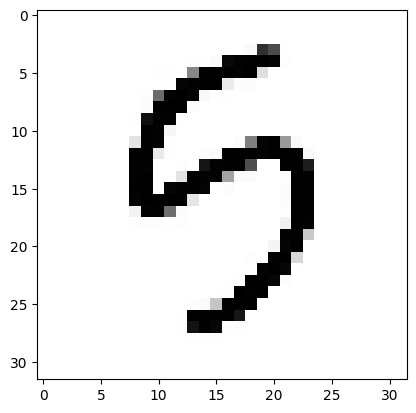

Predicted label for item 44: 2


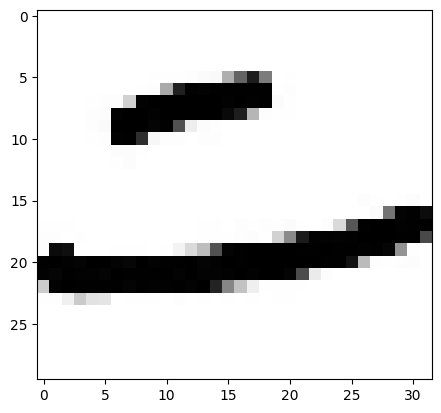

Predicted label for item 45: 7


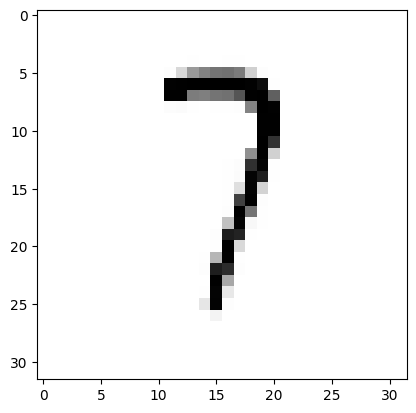

Predicted label for item 46: 6


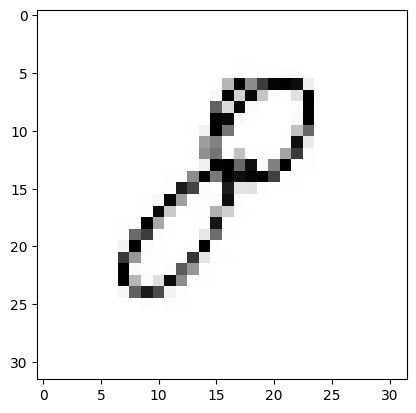

Predicted label for item 47: add


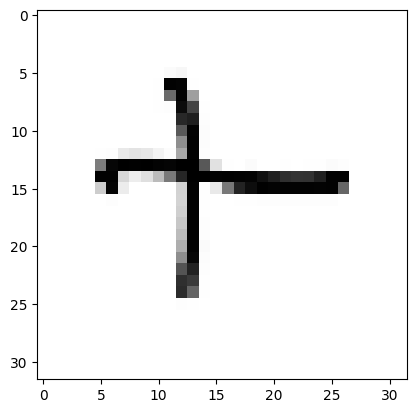

Predicted label for item 48: 1


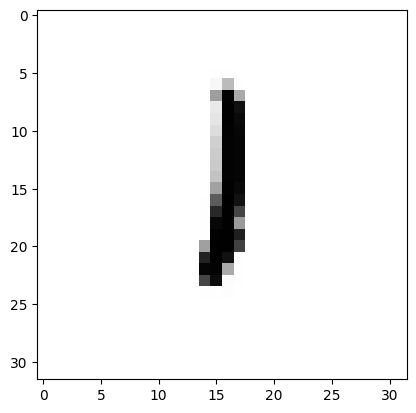

Predicted label for item 49: 4


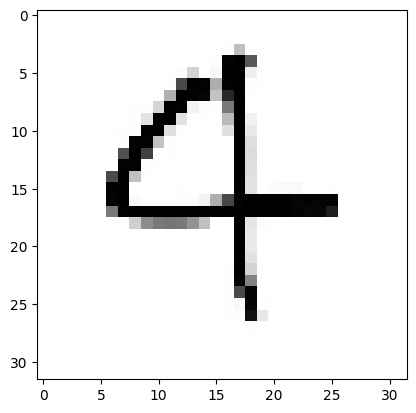

Predicted label for item 50: mul


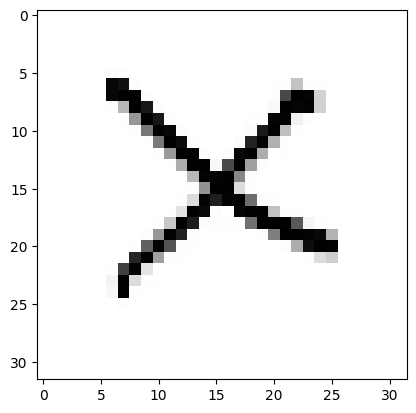

Predicted label for item 51: 8


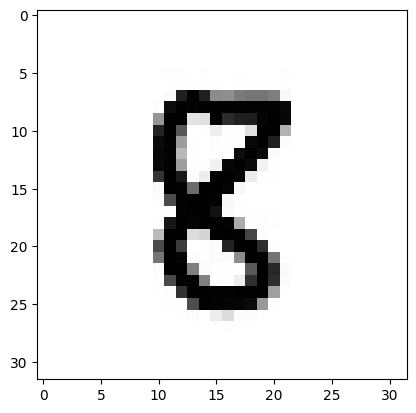

Predicted label for item 52: eq


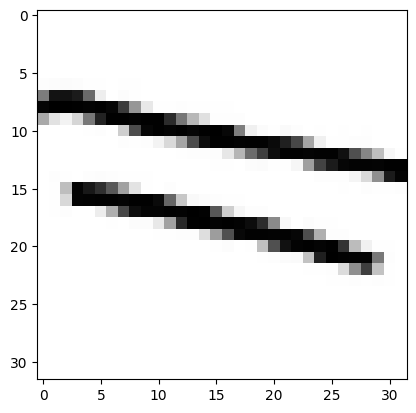

In [ ]:
def predict2(test_loader, model):

  predicted_labels = []
  predicted_output = []
  with torch.no_grad():
    model.eval()
    for data in test_loader:
      y_hat, y_prob = model(data)
      _, predictions = torch.max(y_prob, dim = 1)
      # predicted_labels.append(predictions)
      predicted_labels.extend(predictions.tolist())

    for i, val in enumerate(predicted_labels):
        for key, value in math_map.items():
          if val == value:
            predicted_class = key
            # image = test_loader.dataset[i][0].numpy()  # Fetch the image data
            print(f"Predicted label for item {i}: {predicted_class}")
            predicted_output.append(predicted_class)

            test_loader.dataset.__plot_item__(i)


  return predicted_output
output = predict2(test_loader, model)


In [ ]:
def calculate(math_list):
    temp_list = []
    temp_number = ''
    expressions = []
    expression_string = []
    result = []

    for item in math_list:
        if item.isdigit():
            temp_number += item
        elif item != 'eq':
            if temp_number:
                # temp_list.append(int(temp_number))
                temp_list.append(temp_number)
                temp_number = ''

            if item == 'add':
                operator = '+'
            elif item == 'mul':
                operator = '*'
            elif item == 'sub':
                operator = '-'
            elif item == 'div':
                operator = '/'

            current = len(temp_list)
            if temp_list[current-1].isdigit():
              temp_list.append(operator)
        else:  # item is 'eq'
            if temp_number:
                # temp_list.append(int(temp_number))
                temp_list.append(temp_number)
                temp_number = ''
            expressions.append(temp_list)
            temp_list = []

    if temp_number:
        # temp_list.append(int(temp_number))
        temp_list.append(temp_number)

    if temp_list:  # Append the last sublist if not empty
        expressions.append(temp_list)

    joined_expressions = [''.join(sublist) for sublist in expressions]
    results = [eval(expression) for expression in joined_expressions]

    for i in range(len(expressions)):
        # joined_expression = ''.join(expressions[i])
        print(f"{joined_expressions[i]} = {results[i]}")

calculate(output)

31+73/93 = 31.78494623655914
10-49+1217 = 1178
56/87-75 = -74.35632183908046
88+87-5*57 = -110
78276+14*8 = 78388


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class MLP(nn.Module):

    def __init__(self, layers, dropout_prob=0.5):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.hidden_layers.append(nn.BatchNorm1d(layers[i+1]))  # Add batch normalization
            if i != len(layers)-2:
                self.hidden_layers.append(nn.Tanh())
                self.hidden_layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer after ReLU
        self.hidden_layers = nn.Sequential(*self.hidden_layers)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        logits = self.hidden_layers(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


# Training loop
def train_mlp(model, num_epochs, criterion,optimizer, train_loader, val_loader):
  for epoch in range(num_epochs):
      model.train()  # Set the model to training mode
      for inputs, labels in train_loader:
          optimizer.zero_grad()  # Zero the gradients
          logits, _ = model(inputs)  # Forward pass
          loss = criterion(logits, labels)  # Compute the loss
          loss.backward()  # Backward pass
          optimizer.step()  # Update the weights

      # Validation loop
      model.eval()  # Set the model to evaluation mode
      with torch.no_grad():
          train_loss = 0.0
          train_correct = 0
          train_total = 0

          val_loss = 0.0
          val_correct = 0
          val_total = 0

          for inputs, labels in train_loader:
              logits, _ = model(inputs)  # Forward pass
              loss_train = criterion(logits, labels)  # Compute the loss
              train_loss += loss_train.item()
              _, predicted_train = torch.max(logits, 1)
              train_total += labels.size(0)
              train_correct += (predicted_train == labels).sum().item()

          for inputs, labels in val_loader:
              logits, _ = model(inputs)  # Forward pass
              val_loss = criterion(logits, labels)  # Compute the loss
              val_loss += loss.item()
              _, predicted_val = torch.max(logits, 1)
              val_total += labels.size(0)
              val_correct += (predicted_val == labels).sum().item()

          # train accuracy
          train_accuracy = train_correct / train_total
          avg_train_loss = train_loss / len(train_loader)

          # Calculate validation accuracy and average loss
          val_accuracy = val_correct / val_total
          avg_val_loss = val_loss / len(val_loader)

          # Adjust learning rate based on validation accuracy
          scheduler.step(train_accuracy)
          scheduler.step(val_accuracy)

          # Early stopping: You can implement early stopping here if needed

      print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {avg_train_loss:.4f}, "
          f"Training Accuracy: {100*train_accuracy:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {100*val_accuracy:.4f}")


In [ ]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

MLP(
  (hidden_layers): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=19, bias=True)
  )
)


In [ ]:
# Set up the model, loss function, optimizer, and learning rate scheduler
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Set initial learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)  # Reduce LR on plateau


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
train_mlp(model = model, num_epochs=100, criterion=criterion, optimizer=optimizer, train_loader=train_loader, val_loader=valid_loader)

Epoch 1/100, Training Loss: 2.3257, Training Accuracy: 34.8274, Validation Loss: 0.0388, Validation Accuracy: 31.4991
Epoch 2/100, Training Loss: 2.2037, Training Accuracy: 38.9528, Validation Loss: 0.0371, Validation Accuracy: 34.7412
Epoch 3/100, Training Loss: 2.0023, Training Accuracy: 50.4958, Validation Loss: 0.0316, Validation Accuracy: 43.3373
Epoch 4/100, Training Loss: 1.8864, Training Accuracy: 54.7798, Validation Loss: 0.0339, Validation Accuracy: 45.0625
Epoch 5/100, Training Loss: 1.8945, Training Accuracy: 53.6097, Validation Loss: 0.0273, Validation Accuracy: 44.5866
Epoch 6/100, Training Loss: 1.8020, Training Accuracy: 53.5898, Validation Loss: 0.0274, Validation Accuracy: 44.4378
Epoch 7/100, Training Loss: 1.7077, Training Accuracy: 59.1035, Validation Loss: 0.0299, Validation Accuracy: 47.7097
Epoch 8/100, Training Loss: 1.6872, Training Accuracy: 59.1630, Validation Loss: 0.0284, Validation Accuracy: 47.9179
Epoch 9/100, Training Loss: 1.6780, Training Accuracy: 6

In [ ]:
model, optimizer, performance_2 = training_loop(model, criterion, optimizer, train_loader, valid_loader, 100)

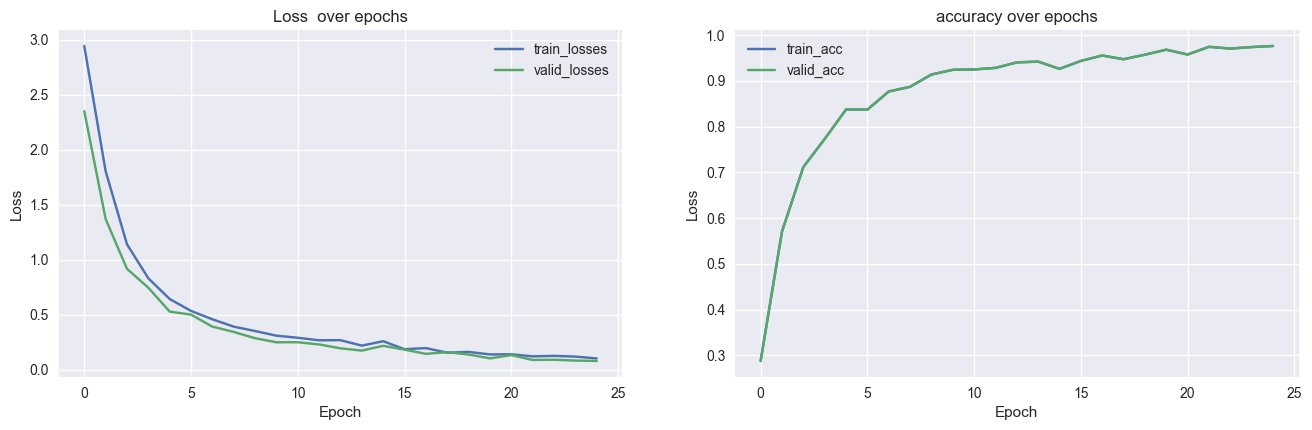

In [ ]:
plot_performance(performance_1)